In [1]:
import numpy as np

In [2]:
class SufficientStatistics:
  def __init__(self):
    self.sum_wzxT = np.array([[0]], dtype=np.float32)
    self.sum_wxxT = np.array([[0]], dtype=np.float32)
    self.sum_xxold = np.array([[0]], dtype=np.float32)
    self.sum_xxoldT = np.array([[0]], dtype=np.float32)
    self.sum_N = np.array([[0]], dtype=np.float32)
    self.sum_wzz = np.array([[0]], dtype=np.float32)
    self.sum_wzx = np.array([[0]], dtype=np.float32)
    self.sum_ExTx = np.array([[0]], dtype=np.float32)
    self.sum_Exxold = np.array([[0]], dtype=np.float32)


In [124]:
def wrkf_learn(x_prev, z, P, A, C, Q, R, ss):
  # A small constant to avoid computationally problems

  SMALL = 1e-6
  
  # Initial priors for weight of the observed data sample

  alpha = 1e-6
  beta = 1e-6

  # Calculate posterior mean and covariance of state

  old_P = P
  r = z - np.dot(C, x_prev)

  tmp_res = np.dot(np.dot(C.transpose(), C), old_P)
  if tmp_res.shape[0] == 1:
    omega = np.dot(r.transpose(), r) + tmp_res
  else:
    omega = np.dot(r.transpose(), r) + np.trace(np.dot(np.dot(C.transpose(), C), old_P))
  
  weight = np.array((alpha + 0.5) / (beta + np.dot(0.5 / (R + SMALL), omega)))

  S = np.dot(np.dot(C, Q), C.transpose()) + R / (weight + SMALL)

  tmp_P = np.dot(weight * C.transpose() / (R + SMALL), C) + 1 / Q + SMALL
  
  if tmp_P.shape[0] == 1:
    P = 1 / tmp_P
  else:
    P = np.linalg.inv(np.dot(weight * C.transpose() / (R + SMALL), C) + 1 / Q + SMALL)
  x = np.dot(np.dot((P / Q), A), x_prev) + np.dot(np.dot(np.dot(weight, P), C.transpose()) / (R + SMALL), z)

  # Update sufficient statistics for A, C, Q and R
  ss.sum_wzxT += np.dot(np.dot(weight, z), x.transpose())

  # raise
  ss.sum_wxxT += np.dot(weight, (np.dot(x, x.transpose()) + P))
  ss.sum_xxold += np.dot(x, x_prev)
  ss.sum_xxoldT += np.dot(x_prev, x_prev.transpose()) + old_P

  ss.sum_N += 1
  ss.sum_wzz += np.dot(weight, np.dot(z.transpose(), z))
  ss.sum_wzx += np.dot(weight, np.dot(z, x))
  ss.sum_ExTx += np.dot(x.transpose(), x) + P
  ss.sum_Exxold += np.dot(x, x_prev)
  
  # raise

  # Calculate new system dynamics
 
  A = ss.sum_xxold / ss.sum_xxoldT
  C = ss.sum_wzxT / ss.sum_wxxT
  R = ss.sum_wzz - 2 * np.sum(np.dot(ss.sum_wzx.transpose(), C)) + np.diag(np.dot(np.dot(C, ss.sum_wxxT), C))
  R = R / ss.sum_N
  Q = ss.sum_ExTx - 2 * np.sum(np.dot(ss.sum_Exxold.transpose(), A)) + np.diag(np.dot(np.dot(A, ss.sum_xxoldT), A))
  Q = Q / ss.sum_N
  
  return x, weight, S, P, A, C, Q, R, ss

[0.8]


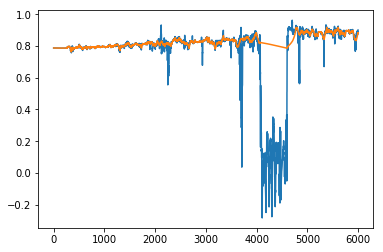

In [127]:
Qoff = np.loadtxt('Qoff.data')

numDim = 1
Yn = Qoff[:, 3]
N = Yn.shape[0]

# Initialize the state estimate, x_hat, to some random value

x_hat_wrKF = np.array([0.8])
print(x_hat_wrKF)

# output
z = []

# Initialize the system matrices
A_wrKF = np.array([[1]])     
C_wrKF = np.array([[1]])
Q_wrKF = np.array([[1e-4]])
R_wrKF = np.array([[1e-4]])

P_wrKF = [1e-2] 

ss = SufficientStatistics()

for i in range(N):

    tmp_x_hat, tmp_weight, tmp_S, P_wrKF, A_wrKF, C_wrKF, Q_wrKF, R_wrKF, ss = wrkf_learn(x_hat_wrKF[i], Yn[i], P_wrKF, A_wrKF, C_wrKF, Q_wrKF, R_wrKF, ss)
    x_hat_wrKF = np.append(x_hat_wrKF, tmp_x_hat)

    z.append(np.dot(C_wrKF, x_hat_wrKF[i + 1]))

import matplotlib.pyplot as plt

plt.plot(range(N), Yn)
plt.plot(range(N), np.array(z).reshape(N))
plt.show()